# Document Classification Test (HeavyWater Machine Learning Challenge)
# LSTM models with document length side feature

**Problem Statement**

We process documents related to mortgages, aka everything that happens to originate a mortgage that you don't see as a borrower. Often times the only access to a document we have is a scan of a fax of a print out of the document. Our system is able to read and comprehend that document, turning a PDF into structured business content that our customers can act on.

This dataset represents the output of the OCR stage of our data pipeline ...  Each word in the source is mapped to one unique value in the output. If the word appears in multiple documents then that value will appear multiple times. The word order for the dataset comes directly from our OCR layer, so it should be roughly in order.

**Mission**

Train a document classification model. Deploy your model to a public cloud platform (AWS/Google/Azure/Heroku) as a webservice, send us an email with the URL to you github repo, the URL of your publicly deployed service so we can submit test cases and a recorded screen cast demo of your solution's UI, its code and deployment steps. Also, we use AWS so we are partial to you using that ... just saying.

**Lightweight way to test for tensorflow detection of GPUs (with diagnostics), using command line:**

```python
python3 -c "from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())"
```

## Setup

### Library import

We import all the required Python libraries

In [1]:
from time import asctime, gmtime, localtime, perf_counter
print(asctime(localtime()))

t0 = perf_counter()

from collections import Counter, OrderedDict
import gc		# garbage collection module
import os
import pathlib
import pickle
from random import random
import sys

print("Python version: ", sys.version_info[:])
print("Un-versioned imports:\n")
prefixStr = ''
print(prefixStr + 'collections', end="  ")
print(prefixStr + 'gc', end="  ")
print(prefixStr + 'os', end="  ")
print(prefixStr + 'pathlib', end="  ")
print(prefixStr + 'pickle', end="  ")
print(prefixStr + 'random', end="  ")
print(prefixStr + 'sys', end="")

import re

from dateutil import __version__ as duVersion
from dateutil.parser import parse
import numpy as np

mdVersion = None
# from modin import __version__ as mdVersion
# import modin.pandas as pd
import pandas as pd
ppVersion = None

import graphviz

scVersion = None
from scipy import __version__ as scVersion
import scipy.sparse as sp

from sklearn import __version__ as skVersion
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

tfVersion = None
from tensorflow import __version__ as tfVersion
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model as load
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.python.client import device_lib 
from tensorflow import device
from tensorflow.keras.metrics import SparseCategoricalCrossentropy

tfaVersion = None
from tensorflow_addons import __version__ as tfaVersion
from tensorflow_addons.metrics import F1Score

# from joblib import __version__ as jlVersion
# from joblib import dump, load

# Visualizations

mpVersion = None
from matplotlib import __version__ as mpVersion
import matplotlib.pyplot as plt

import seaborn as sns
import colorcet as cc

print("\n")
print(f"colorcet: {cc.__version__}", end="\t")
print(f"dateutil: {duVersion}", end="\t")
print(f"graphviz: {duVersion}", end="\t")
# print(f"joblib: {jlVersion}", end="\t")
print(f"matplotlib: {mpVersion}", end="\t")
if 'modin' in sys.modules:
    print(f"modin: {mdVersion}", end="\t")
print(f"numpy: {np.__version__}", end="\t")
if 'pandas' in sys.modules:
    print(f"pandas: {pd.__version__}", end="\t")
print(f"re: {re.__version__}", end="\t")
print(f"scipy: {scVersion}", end="\t")
print(f"seaborn: {sns.__version__}", end="\t")
print(f"sklearn: {skVersion}", end="\t")
print(f"tensorflow: {tfVersion}", end="\t")
print(f"tensorflow_addons: {tfaVersion}", end="\t")

Δt = perf_counter() - t0
print(f"\n\nΔt: {Δt: 4.1f}s.")

print("\nlocal devices:\n\n", device_lib.list_local_devices())

%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

Wed Jan 27 20:47:50 2021
Python version:  (3, 6, 9, 'final', 0)
Un-versioned imports:

collections  gc  os  pathlib  pickle  random  sys

colorcet: 1.0.0	dateutil: 2.8.1	graphviz: 2.8.1	matplotlib: 3.3.3	numpy: 1.19.5	pandas: 1.1.4	re: 2.2.1	scipy: 1.4.1	seaborn: 0.11.1	sklearn: 0.22.1	tensorflow: 2.4.1	tensorflow_addons: 0.12.0	

Δt:  2.2s.

local devices:

 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8311885169025908834
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8500775488
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 6046949416930270217
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10767488768
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 726879

**Next two lines are for pretty output for all prints in a Pandas cell, not just the last**

In [34]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Local library import

We import all the required local libraries libraries

In [2]:
rootPath = pathlib.Path.cwd().parent
libPath = rootPath / 'python'

# Include local library paths
sys.path.append(str(libPath)) # uncomment and fill to import local libraries

# Import local libraries
from utility import ModelTrain as mt
from plotHelpers import plotHelpers as ph

<a id="helper-tokenize"></a>
### Helper functions

#### `tokenize()`

In [3]:
def tokenize(corpus, vocabSz):
    """
    Generates the vocabulary and the list of list of integers for the input corpus

    Help from: https://www.tensorflow.org/tutorials/text/nmt_with_attention

    INPUTS:
        corpus: list, type(str), containing (short) document strings
        vocabSz: (int) Maximum number of words to consider in the vocabulary

    RETURNS: List of list of indices for each string in the corpus + Keras sentence tokenizer object

    Usage:
        listOfListsOfIndices, sentenceTokenizer = tokenize(mySentences, maxVocabCt)
    """

    # Define the sentence tokenizer
    tokenizer = Tokenizer(num_words=vocabSz,
    #                               filters='!#%()*+,./:;<=>?@[\\]^_`{|}~\t\n',
                                  filters='%',
                                  lower=False,
                                  split=' ', char_level=False, oov_token="<unkwn>")

    # Keep the double quote, dash, and single quote + & (different from word2vec training: didn't keep `&`)
    # oov_token: added to word_index & used to replace out-of-vocab words during text_to_sequence calls
    # num_words = maximum number of words to keep, dropping least frequent

    # Fit the tokenizer on the input corpus
    tokenizer.fit_on_texts(corpus)

    # Transform each text in corpus to a sequence of integers
    listOfIndexLists = tokenizer.texts_to_sequences(corpus)

    return listOfIndexLists, tokenizer

## Prepare Data

#### Define paths

In [4]:
dataPath = rootPath / 'data'
modelPath = rootPath / 'model'
plotPath = rootPath / 'figures'
checkpointPath = rootPath / 'checkpoints'
tensorBoardPath = rootPath / 'tensorBoardLogs'

### Import data

In [5]:
sourceData = dataPath / 'shuffled-full-set-hashed.csv.zip'
df0 = pd.read_csv(sourceData, header=None, names=['category', 'docText'])
df0.head()
df0.tail()

,category,docText
62199,CANCELLATION NOTICE,6bf9c0cb01b4 52102c70348d 1b6d0614f2c7 246ee0c...
62200,BINDER,816aed74475e 288ccf089872 fe33912c5732 5d00ab6...
62201,BILL,f95d0bea231b 894305951372 c9a53ea6e219 8f6018d...
62202,CANCELLATION NOTICE,5ee06767bc0f 106de4332a24 46a0c35e916c 54709b2...
62203,CANCELLATION NOTICE,586242498a88 21e314d3afcc 818a7ff3bf29 4e43b72...


### Munge/inspect data

**There are 45 null documents**

In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62204 entries, 0 to 62203
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  62204 non-null  object
 1   docText   62159 non-null  object
dtypes: object(2)
memory usage: 972.1+ KB


**There are 14 document categories**

In [7]:
categories = df0.category.unique()
len(categories)
print(categories)

['DELETION OF INTEREST' 'RETURNED CHECK' 'BILL' 'POLICY CHANGE'
 'CANCELLATION NOTICE' 'DECLARATION' 'CHANGE ENDORSEMENT'
 'NON-RENEWAL NOTICE' 'BINDER' 'REINSTATEMENT NOTICE' 'EXPIRATION NOTICE'
 'INTENT TO CANCEL NOTICE' 'APPLICATION' 'BILL BINDER']


#### Extract tokens (in order to get document lengths)

In [8]:
df0['tokens'] = df0.docText.apply(lambda p: [] if isinstance(p, float) else p.split())
df0.head()

,category,docText,tokens
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...,"[e04a09c87692, d6b72e591b91, 5d066f0246f1, ed4..."
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...,"[a3b334c6eefd, be95012ebf2b, 41d67080e078, ff1..."
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...,"[586242498a88, 9ccf259ca087, 54709b24b45f, 6bf..."
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...,"[cd50e861f48b, 6ca2dd348663, d38820625542, f07..."
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...,"[9db5536263d8, 1c303d15eb65, 3f89b4673455, b73..."


#### Get token counts (side feature)

In [9]:
df0['docLength'] = df0.tokens.apply(lambda t: len(t))
df0.head()

,category,docText,tokens,docLength
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...,"[e04a09c87692, d6b72e591b91, 5d066f0246f1, ed4...",465
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...,"[a3b334c6eefd, be95012ebf2b, 41d67080e078, ff1...",403
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...,"[586242498a88, 9ccf259ca087, 54709b24b45f, 6bf...",185
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...,"[cd50e861f48b, 6ca2dd348663, d38820625542, f07...",337
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...,"[9db5536263d8, 1c303d15eb65, 3f89b4673455, b73...",546


## Pre-process data

### Test-train split

* remove documents of length < <font color="darkred">**6**</font>:
  * these are unlikely to be informative, and probably are result of scan error
  * probably should have these labeled as an error, for human review, rather than risk downstream adoption
* class imbalance spanning almost 2 orders of magnitude ⟶ *stratified sampling*
* smallest classes 229 instances, so need half to test with ~10% uncertainty
* after model selection, can train on entire data set

In [10]:
df = df0.copy()[df0.docLength > 5]
df0.shape, df.shape

((62204, 4), (62112, 4))

In [11]:
randomState = np.random.RandomState(11)

dfTr, dfTe = train_test_split(df, test_size=0.5, shuffle=True,
                              random_state=randomState, stratify=df.category)
dfTr.shape, dfTe.shape
dfTr.head()
dfTe.head()

,category,docText,tokens,docLength
3351,DECLARATION,a0c020166d79 133d46f7ed38 fe64d3cdfe5b 36e7aa7...,"[a0c020166d79, 133d46f7ed38, fe64d3cdfe5b, 36e...",675
38868,BINDER,d9ef68daef4c 04503bc22789 afb1e3806fc1 e7e059c...,"[d9ef68daef4c, 04503bc22789, afb1e3806fc1, e7e...",275
21988,CHANGE ENDORSEMENT,5e99d31d8fa4 b99d622bf8e3 ecb0dd7353a4 816a114...,"[5e99d31d8fa4, b99d622bf8e3, ecb0dd7353a4, 816...",110
57907,BILL,3572a5c01503 21ab107e9310 a1fde4983c10 8ba05d1...,"[3572a5c01503, 21ab107e9310, a1fde4983c10, 8ba...",251
49746,BINDER,33a62c972b6f c4f716054f25 93202e5da9ab ba02159...,"[33a62c972b6f, c4f716054f25, 93202e5da9ab, ba0...",368


### Create list of lists of word indices, and TensorFlow sentence tokenizer object

Use strings from `dfTrain` to create vocabulary indices.

See [helper function `tokenize()`](#helper-tokenize)

* Each token is 12 characters long, so minimum string length is 6 &times; 12 + 5 (spaces) = 77

<a id="maxvocabct"></a>
Must specify a limit to the number of unique tokens for the tokenizer.
(Changing this will require re-instantiating it.)

* `maxVocabCt`			vocabulary size to be returned by tokenizer, dropping least frequent

Other parameters are defined below in [LSTM 0, baseline model parameters](#lstm0-parameters), and similarly for subsequent models.

Tokenizing takes ~10 s.

In [12]:
maxVocabCt = 200_000

In [13]:
df.docText.str.len().min()
ListOfDocsTr = list(dfTr.docText)
listOfListsOfWordIndicesTr, tokenizer = tokenize(ListOfDocsTr, maxVocabCt)

### Compute weights for each class

#### `dfTr` category breakdowns

* categoriesBySupport are category names ordered by support in `dfTr`

In [14]:
categoryCts = dfTr[['category', 'docLength']].groupby(by='category').count()\
    .rename(columns={'docLength': 'count'})
categoryCts

categoryCts.sort_values(by='count', ascending=False)
categoriesBySupport = list(categoryCts.sort_values(by='count', ascending=False).index)
categoriesBySupport

['BILL',
 'POLICY CHANGE',
 'CANCELLATION NOTICE',
 'BINDER',
 'DELETION OF INTEREST',
 'REINSTATEMENT NOTICE',
 'DECLARATION',
 'CHANGE ENDORSEMENT',
 'RETURNED CHECK',
 'EXPIRATION NOTICE',
 'NON-RENEWAL NOTICE',
 'BILL BINDER',
 'APPLICATION',
 'INTENT TO CANCEL NOTICE']

#### Extract training and test labels

In [15]:
categoryInds = {c: i for c, i in zip(categoriesBySupport, range(len(categories)))}

yTr = dfTr.category.apply(lambda c: categoryInds[c])
yTe = dfTe.category.apply(lambda c: categoryInds[c])
yTr.head()
yTr.tail()

50767    10
57781     5
58144     3
1313      0
16969     5
Name: category, dtype: int64

#### Determine class weights

In [16]:
weights = class_weight.compute_class_weight('balanced',
                                            range(len(categories)),
                                            yTr)
print(weights)
classWeights = {i: weights[i] for i in range(len(categories))}
print("classWeights:\n", classWeights)

[ 0.23411986  0.41878152  0.45606203  0.49637183  0.91930614  1.01569859
  4.59272405  4.98491172  5.91542857  6.04437524  7.10989011 15.4047619
 19.45864662 19.45864662]
classWeights:
 {0: 0.2341198643045609, 1: 0.41878152053723133, 2: 0.456062030075188, 3: 0.4963718313460985, 4: 0.9193061393641584, 5: 1.0156985871271587, 6: 4.592724046140195, 7: 4.984911717495987, 8: 5.9154285714285715, 9: 6.044375243285325, 10: 7.1098901098901095, 11: 15.404761904761905, 12: 19.458646616541355, 13: 19.458646616541355}


## LSTM model(s)

* This/these differ from simple models, as they include a side feature `docLength`
* Since a substantial fraction of documents have lengths `docLength > maxDocWords`, this feature should be informative

<a id="define-model1"></a>
### Define model1

* embedding layer
* bidirectional LSTM
* unidirectional LSTM *(optional)*
* dense layer (relu)
* dense layer (relu)
* classifier dense layer (softmax)

In [17]:
def model1(sequence_length, vocabSz, auxFeatureCount, LSTMinternalLayerSz,
           embedLayerDim, densLayerDim=64, softMaxCt=16, dropoutFrac=0.15,
           LSTMdropoutFrac=0.40, include2ndLSTMlayer=False):

    """
    INPUTS:
    sequence_length			int, number of LSTM units
    vocabSz					int, size of vocabulary
    auxFeatureCount			int, count of auxiliary (side) features
    LSTMinternalLayerSz		int, size of layers within LSTM units
    embedLayerDim			int, dimension of embedding layer
    densLayerDim			int, dimension of dense layers, default: 64
    softMaxCt				int, dimension of softmax output, default: 16
    dropoutFrac				int, dropout rate, default: 0.15
    LSTMdropoutFrac			int, dropout rate for LSTMs, default: 0.40
    include2ndLSTMlayer		bool, include unidirectional LSTM after
                            bidirectional LSTM, default: False
    """

    # Headline input: meant to receive sequences of *sequence_length*
    # integers, between 1 and *vocabSz*.

    main_input = Input(shape=(sequence_length,), dtype='int32', name='MainInput')
    auxiliary_input = Input(shape=(auxFeatureCount,), name='NumericalInput')

    # This embedding layer will encode the input sequence
    # into a sequence of dense 64-dimensional vectors.
    x = Embedding(output_dim=embedLayerDim, input_dim=vocabSz,
                  input_length=sequence_length, trainable=True, name="EmbedLayer")(main_input)

    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    lstmOut0 = Bidirectional(LSTM(LSTMinternalLayerSz,
                                    dropout=dropoutFrac,
                                    recurrent_dropout=LSTMdropoutFrac,
                                    return_sequences=False), name='BidirectionalLSTM')(x)
                                    # return_sequences=True), name='BidirectionalLSTM')(x)
    if not include2ndLSTMlayer:
        x = concatenate([lstmOut0, auxiliary_input], name='ConcatenatedFeatures')
    else:
        # Add a second, unidirectional LSTM, if desired
        lstmOut1 = LSTM(LSTMinternalLayerSz,
                        dropout=dropoutFrac,
                        recurrent_dropout=LSTMdropoutFrac, name='UnidirectionalLSTM')(lstmOut0)
        x = concatenate([lstmOut1, auxiliary_input], name='ConcatenatedFeatures')

    # We stack a deep densely-connected network on top
    x = Dense(densLayerDim, activation='relu', name='DenseLayer0')(x)
    x = Dense(densLayerDim, activation='relu', name='DenseLayer1')(x)

    # And finally we add the main logistic regression layer
    main_output = Dense(56, activation='softmax', name='mainOutput')(x)
    model = Model(inputs=[main_input, auxiliary_input], outputs=main_output)

    return model

<a id="tokenize-512-tokens"></a>
### LSTM 6 tokenize

* truncate docs to `maxDocWords = 512` tokens
* pre-pad shorter docs with 0s

##### Tensor of word indices for train

In [18]:
padValue = 0
maxDocWords = 384

XdocsTr = pad_sequences(listOfListsOfWordIndicesTr,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [19]:
ListOfDocsTr[0]
print(listOfListsOfWordIndicesTr[0])
XdocsTr[0]

[673, 8480, 1911, 176125, 29094, 176126, 33264, 157, 1395, 399, 6626, 33265, 104525, 20636, 4438, 5594, 4, 214, 1327, 73, 204, 17094, 4687, 36, 176127, 32, 176128, 224, 182, 12, 42966, 32, 21, 10648, 176129, 256, 104526, 23, 36, 32, 407, 184, 52, 299, 33266, 17, 4, 49, 226, 49, 22415, 49, 52, 49, 49, 943, 1411, 29095, 648, 350, 104527, 369, 79132, 726, 723, 568, 265, 4916, 1308, 176130, 47871, 176131, 44, 63, 33, 23, 36, 32, 36, 7511, 176132, 19, 530, 753, 2829, 878, 5595, 21, 35843, 3240, 1170, 73, 153, 9140, 54, 935, 11657, 8722, 176133, 2550, 299, 673, 1333, 176134, 655, 17095, 5972, 407, 42, 130, 867, 1695, 53, 250, 380, 7, 175, 867, 27, 146, 42, 22416, 104528, 3284, 21, 12, 5230, 27, 104528, 8481, 176135, 31, 177, 655, 42967, 104529, 51, 218, 15, 1385, 402, 381, 176136, 101, 42, 176137, 407, 655, 73, 176138, 21, 52, 1029, 17, 6, 326, 122, 577, 5654, 19, 232, 15, 183, 110, 233, 15, 90, 44, 188, 41, 104529, 47, 100, 8, 33, 57, 38, 49, 5509, 225, 33, 136, 78, 19, 232, 15, 77, 142, 45

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,    673,   8480,   1911,
       176125,  29094, 176126,  33264,    157,   1395,    399,   6626,
        33265, 104525,  20636,   4438,   5594,      4,    214,   1327,
           73,    204,  17094,   4687,     36, 176127,     32, 176128,
          224,    182,     12,  42966,     32,     21,  10648, 176129,
          256, 104526,     23,     36,     32,    407,    184,     52,
          299,  33266,     17,      4,     49,    226,     49,  22415,
      

##### Tensor of word indices for test

In [20]:
ListOfDocsTe = list(dfTe.docText)
listOfListsOfWordIndicesTe = tokenizer.texts_to_sequences(ListOfDocsTe)
XdocsTe = pad_sequences(listOfListsOfWordIndicesTe,
                        maxlen=maxDocWords,
                        dtype='int32', padding='pre',
                        truncating='post', value=padValue)

In [21]:
ListOfDocsTe[0]
print(listOfListsOfWordIndicesTe[0])
XdocsTe[0]

[71, 9, 118, 53, 209, 8795, 269, 171, 19, 808, 249, 118, 83, 1, 178, 2313, 1188, 135, 232, 218, 4, 1261, 301, 291, 1240, 3305, 372, 1, 1307, 6, 30555, 2, 97, 1037, 647, 286, 707, 4109, 465, 20, 1, 13429, 6, 1233, 366, 125, 128, 7828, 490, 1268, 2177, 7720, 8, 132, 6, 872, 29, 1574, 2, 825, 6, 549, 559, 231, 261, 6, 6289, 579, 244, 574, 23, 1104, 163, 135, 101, 9, 78, 8795, 174, 31526, 1093, 357, 30, 135, 9, 109, 184, 370, 465, 17995, 8790, 787, 6, 218, 1788, 141375, 1759, 1991, 266, 787, 2179, 228, 2278, 30, 2201, 494, 2338, 86, 662, 816, 72, 922, 1037, 286, 291, 3305, 4, 3, 165, 1, 353, 23, 367, 8795, 9, 3690, 19, 283, 73, 266, 3, 3283, 122, 165, 209, 269, 2313, 1, 1, 119, 28820, 171, 180, 3, 4165, 80, 9855, 1261, 19, 688, 6, 218, 2, 412, 132, 8795, 16, 19, 78, 132, 871, 78, 132, 14, 1718, 6850, 18129, 208, 37, 943, 1, 4736, 195, 120, 464, 53, 8795, 197, 229, 90, 233, 6, 835, 835, 340, 56, 370, 2, 257, 8, 8795, 2, 149, 13929, 505, 27, 84, 19, 158, 15, 190, 457, 1431, 2378, 409, 743, 3

array([    71,      9,    118,     53,    209,   8795,    269,    171,
           19,    808,    249,    118,     83,      1,    178,   2313,
         1188,    135,    232,    218,      4,   1261,    301,    291,
         1240,   3305,    372,      1,   1307,      6,  30555,      2,
           97,   1037,    647,    286,    707,   4109,    465,     20,
            1,  13429,      6,   1233,    366,    125,    128,   7828,
          490,   1268,   2177,   7720,      8,    132,      6,    872,
           29,   1574,      2,    825,      6,    549,    559,    231,
          261,      6,   6289,    579,    244,    574,     23,   1104,
          163,    135,    101,      9,     78,   8795,    174,  31526,
         1093,    357,     30,    135,      9,    109,    184,    370,
          465,  17995,   8790,    787,      6,    218,   1788, 141375,
         1759,   1991,    266,    787,   2179,    228,   2278,     30,
         2201,    494,   2338,     86,    662,    816,     72,    922,
      

#### Auxiliary (side) data need to be shaped

* creates a row vector

In [35]:
XauxTr = dfTr.docLength.values.reshape(dfTr.shape[0], 1)
XauxTr.shape
XauxTe = dfTe.docLength.values.reshape(dfTe.shape[0], 1)
XauxTe.shape

(31056, 1)

(31056, 1)

<a id="lstm6-parameters"></a>
### LSTM 6

#### baseline model parameters

* Bidirectional(LSTM) only
* `LSTMlayerUnits = 128`
* `maxDocWords = 384`

Refer to the [LSTM 6 tokenize](#tokenize-512-tokens) section for the size of `maxVocabCt`.

|parameter|&nbsp;&nbsp;|description|
|:--------|------------|:----------|
|`testFrac`||fraction of data set withheld|
|`LSTMlayerUnits`||# units within each activation unit in LSTMs|
|`embeddingDim'||size of dimension for generated embeddings|
|`auxFeaturesCt`||# of features in auxiliary data|
|`classCt`||# classes (softmax output dim)|
|`auxFeatureCount`||# of side features|
|`dropoutFrac`||dropout fraction|
|`LSTMdropoutFrac`||dropout fraction within LSTMs|
|`batchSz`||size of batches|
|`epochCt`||number of epochs to run|

In [23]:
testFrac = 0.5
LSTMlayerUnits = 128		# 🢢🢢🢢
embeddingDim = 64
classCt = len(categoriesBySupport)
auxFeatureCount = 1
dropoutFrac = 0.15
LSTMdropoutFrac = 0.5
# LSTMdropoutFrac = 0			# Must be 0 for use of cudnn
batchSz = 64
epochCt = 30

#### Save space

In [24]:
# del LSTMX		# (placeholder, in case this section copied for subsequent models)

#### LSTM 6 callbacks

* checkpoints
* TensorBoard
* (no early stopping)

In [25]:
modelInstanceDir = (f"vocabCt{maxVocabCt:06d}maxCommentLen{maxDocWords:03d}"
                    + f"classCt{classCt:02d}"
                    + f"embedDim{embeddingDim:03d}"
                    + f"LSTMlayerSz{LSTMlayerUnits:03d}batchSz{batchSz:03d}"
                    + f"dropoutFrac{dropoutFrac:4.2f}"
                    + f"LSTMdropoutFrac{dropoutFrac:4.2f}")
print(modelInstanceDir, "\n")

checkpointPrefix = os.path.join(checkpointPath, modelInstanceDir,
                                "ckpt{epoch:03d}")
print(checkpointPrefix, "\n")

checkpointCallback=ModelCheckpoint(filepath=checkpointPrefix,
                                   save_weights_only=True)
os.makedirs(tensorBoardPath, exist_ok=True)                       

logsDir = os.path.join(tensorBoardPath, modelInstanceDir)
print(logsDir, "\n")

os.makedirs(logsDir, exist_ok=True)
tensorboardCallback = TensorBoard(log_dir=logsDir, histogram_freq=1)

vocabCt200000maxCommentLen384classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 

/home/mark/work/document-classification-test/checkpoints/vocabCt200000maxCommentLen384classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15/ckpt{epoch:03d} 

/home/mark/work/document-classification-test/tensorBoardLogs/vocabCt200000maxCommentLen384classCt14embedDim064LSTMlayerSz128batchSz064dropoutFrac0.15LSTMdropoutFrac0.15 



#### Load or instantiate LSTM 6

In [26]:
LSTM6name = 'LSTM6'

if (modelPath / LSTM6name).is_file():
    print(f"Loading {LSTM6name} model from disk.")
    LSTM6 = load(modelPath / LSTM6name)
else:
    np.random.seed(0)  # Set a random seed for reproducibility

    print("Instantiate LSTM 6, using model0 ...")
    with device('/device:GPU:1'):
        LSTM6 = model1(maxDocWords, maxVocabCt, auxFeatureCount, classCt, LSTMlayerUnits,
                       embeddingDim, softMaxCt=classCt)
    LSTM6.summary()

Instantiate LSTM 6, using model0 ...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MainInput (InputLayer)          [(None, 384)]        0                                            
__________________________________________________________________________________________________
EmbedLayer (Embedding)          (None, 384, 128)     25600000    MainInput[0][0]                  
__________________________________________________________________________________________________
BidirectionalLSTM (Bidirectiona (None, 28)           16016       EmbedLayer[0][0]                 
__________________________________________________________________________________________________
NumericalInput (InputLayer)     [(None, 1)]          0                                            
_________________________________________________________

<a id="model1-graph"></a>
#### Model 1 graph

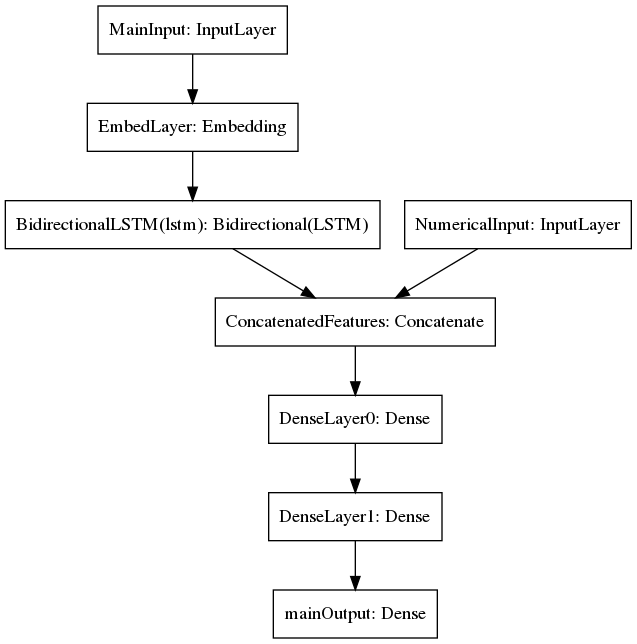

In [32]:
plot_model(LSTM6, to_file=os.path.join(plotPath, 'model1graph.png'))

#### Compile LSTM 6

In [28]:
if not (modelPath / LSTM6name).is_file():
    with device('/device:GPU:1'):
      LSTM6.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  # metrics = ['accuracy', Recall(), Precision(),
                  #            F1Score(num_classes=classCt), 'categorical_crossentropy'])
                  metrics = ['accuracy'])

#### Train LSTM 6

In [29]:
if not (modelPath / LSTM6name).is_file():
    print(epochCt, batchSz)
    print(classWeights)
    with device('/device:GPU:1'):
        history6 = LSTM6.fit(x=[XdocsTr, XauxTr],
                             y= yTr.values,
                             epochs=epochCt, batch_size=batchSz,
                             shuffle=True,
                             class_weight=classWeights,
                             validation_split=0.2,
                             callbacks=[checkpointCallback, tensorboardCallback],
                             verbose=1)

30 64
{0: 0.2341198643045609, 1: 0.41878152053723133, 2: 0.456062030075188, 3: 0.4963718313460985, 4: 0.9193061393641584, 5: 1.0156985871271587, 6: 4.592724046140195, 7: 4.984911717495987, 8: 5.9154285714285715, 9: 6.044375243285325, 10: 7.1098901098901095, 11: 15.404761904761905, 12: 19.458646616541355, 13: 19.458646616541355}
Epoch 1/30
389/389 [==============================] - 772s 2s/step - loss: 10.7862 - accuracy: 0.0859 - val_loss: 4.2130 - val_accuracy: 0.1713
Epoch 2/30
389/389 [==============================] - 752s 2s/step - loss: 3.2669 - accuracy: 0.1907 - val_loss: 1.9828 - val_accuracy: 0.2693
Epoch 3/30
389/389 [==============================] - 750s 2s/step - loss: 2.9583 - accuracy: 0.2595 - val_loss: 3.8254 - val_accuracy: 0.1652
Epoch 4/30
389/389 [==============================] - 751s 2s/step - loss: 2.6164 - accuracy: 0.3365 - val_loss: 1.7330 - val_accuracy: 0.5261
Epoch 5/30
389/389 [==============================] - 750s 2s/step - loss: 2.0124 - accuracy: 0.4

#### Save LSTM 6, if new model

In [30]:
if not (modelPath / LSTM6name).is_file():
    print(f"Saving {LSTM6name} to disk.")
    LSTM6.save(modelPath / LSTM6name)

Saving LSTM6 to disk.
INFO:tensorflow:Assets written to: /home/mark/work/document-classification-test/model/LSTM6/assets


#### LSTM 6 inference on test data

In [37]:
softmaxOut = LSTM6.predict(x=[XdocsTe, XauxTe])
yPred = np.argmax(softmaxOut, axis=1)

In [38]:
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

[[6710  390  436  100   17  329  297   84   84  311    9  568  107   33]
 [ 116 3280   68  348   20  123  429  192   86   46   32  301  200   56]
 [ 144   49 3541   27  355  200  123    5    9  256   45   11    7   93]
 [  36  563   31 3000    4   12  460   36   30    1    9   99  182    6]
 [   3    9  325    3 1936    7   80    2    0    4   27    2    1   14]
 [  37   36  123    0    5 1737   31    6    2  171    5   10    4   16]
 [  37  108   26  111    9   17  116   11    6    3    4    8   23    4]
 [   2   39    5    3    0    7   15  335    9    2    1   15    6    5]
 [  11   15    2    2    0    0    4    5  297    1    1   18   15    3]
 [  36    5   28    1    2   33   16    0    1  233    2    4    1    5]
 [   1    5   56    5   28    1   20    1    1    5  182    2    1    4]
 [  23   22    1    8    0    2   24    8    4    1    0   39   11    1]
 [   1   23    0   10    0    0    9    0    3    1    0    7   61    0]
 [  13    1   29    0    3   10    7    0    0    2

In [39]:
np.where(np.sum(confusionMat, axis=0) == 0)

(array([], dtype=int64),)

In [40]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.693, <precision>: 0.499, <recall>: 0.611


##### Classification report

In [41]:
classificationReport = classification_report(yTe.values, yPred,
                                             target_names=[str(c)for c in categoriesBySupport])
print(classificationReport)

                         precision    recall  f1-score   support

                   BILL       0.94      0.71      0.81      9475
          POLICY CHANGE       0.72      0.62      0.67      5297
    CANCELLATION NOTICE       0.76      0.73      0.74      4865
                 BINDER       0.83      0.67      0.74      4469
   DELETION OF INTEREST       0.81      0.80      0.81      2413
   REINSTATEMENT NOTICE       0.70      0.80      0.75      2183
            DECLARATION       0.07      0.24      0.11       483
     CHANGE ENDORSEMENT       0.49      0.75      0.59       444
         RETURNED CHECK       0.56      0.79      0.66       374
      EXPIRATION NOTICE       0.22      0.63      0.33       367
     NON-RENEWAL NOTICE       0.57      0.58      0.58       312
            BILL BINDER       0.04      0.27      0.06       144
            APPLICATION       0.10      0.53      0.17       115
INTENT TO CANCEL NOTICE       0.17      0.43      0.24       115

               accuracy

##### Sorted classification report

* order by support

In [42]:
print(ph.sortClassificationReport(classificationReport))

                         precision    recall  f1-score   support

                   BILL       0.94      0.71      0.81      9475
          POLICY CHANGE       0.72      0.62      0.67      5297
    CANCELLATION NOTICE       0.76      0.73      0.74      4865
                 BINDER       0.83      0.67      0.74      4469
   DELETION OF INTEREST       0.81      0.80      0.81      2413
   REINSTATEMENT NOTICE       0.70      0.80      0.75      2183
            DECLARATION       0.07      0.24      0.11       483
     CHANGE ENDORSEMENT       0.49      0.75      0.59       444
         RETURNED CHECK       0.56      0.79      0.66       374
      EXPIRATION NOTICE       0.22      0.63      0.33       367
     NON-RENEWAL NOTICE       0.57      0.58      0.58       312
            BILL BINDER       0.04      0.27      0.06       144
            APPLICATION       0.10      0.53      0.17       115
INTENT TO CANCEL NOTICE       0.17      0.43      0.24       115

               accuracy

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [43]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

fileNameAugmentString:
 Lstm6
Δt:  0.45s.


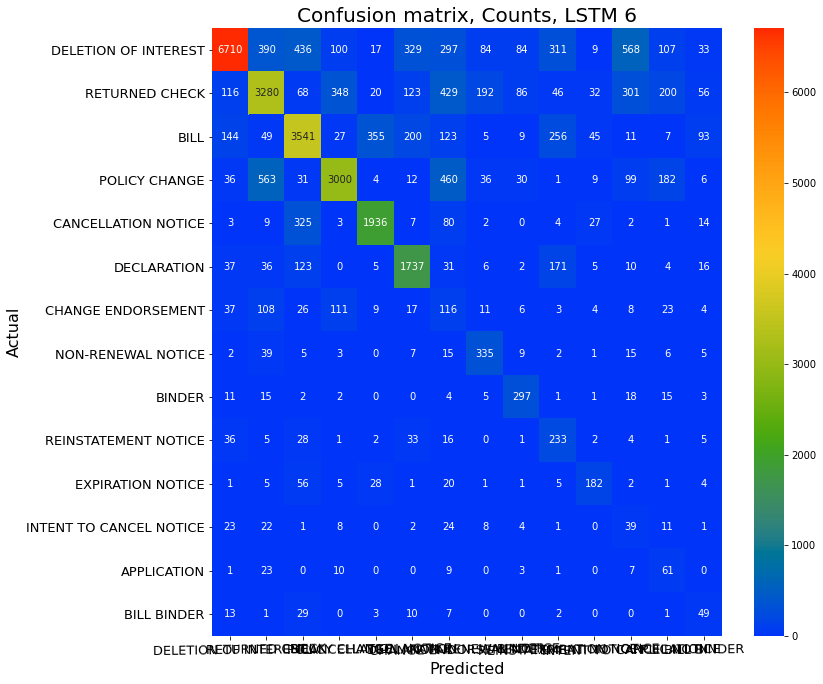

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 6',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix

* normalized by *row*
* diagonal elements now represent the *recall* for each class

fileNameAugmentString:
 Lstm6
Δt:  1.35s.


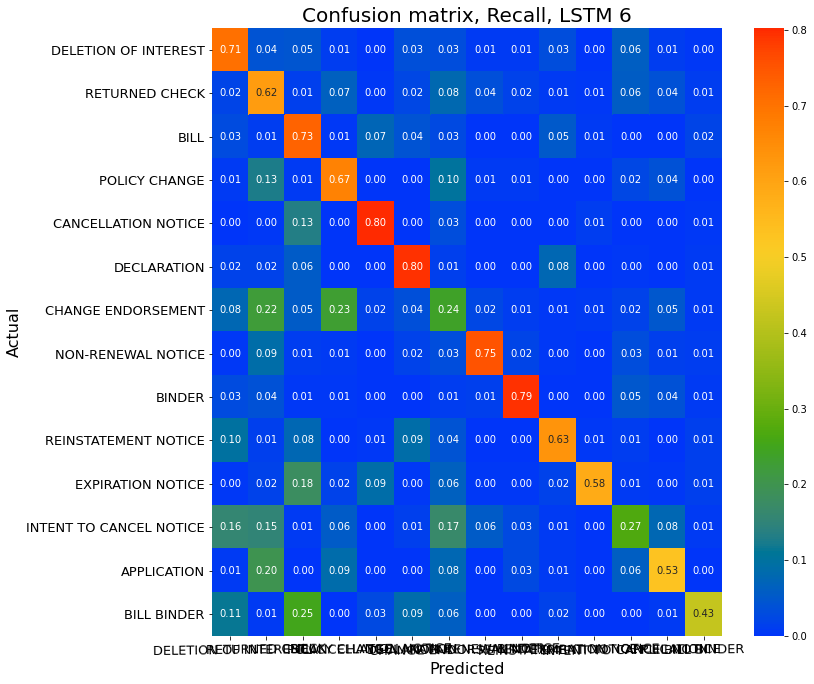

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 6',
                       ax = ax, xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='recall',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix

* normalized by *column*
* diagonal elements now represent the *precision* for each class

fileNameAugmentString:
 Lstm6
Δt:  0.38s.


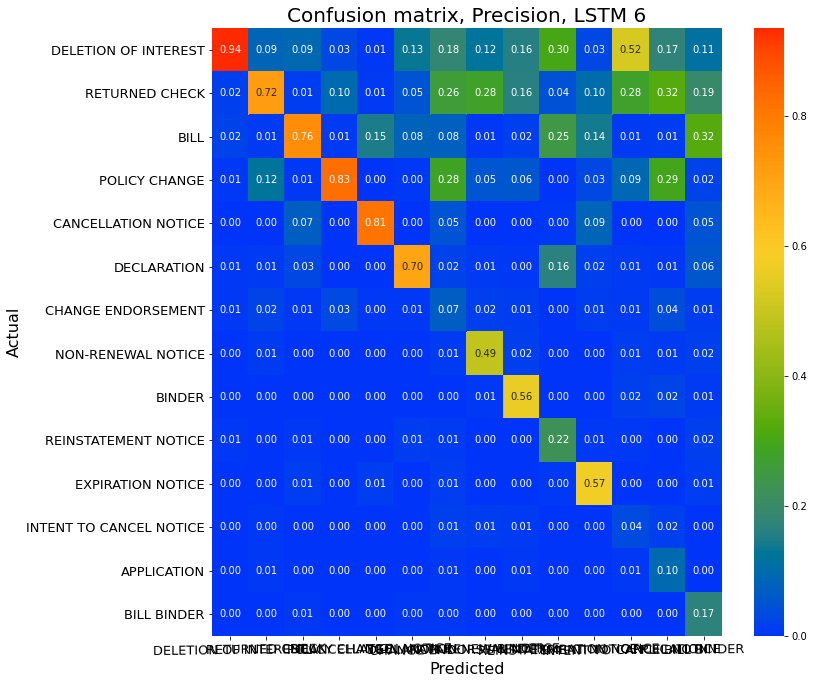

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ph.plotConfusionMatrix(confusionMat, saveAs=None, xlabels=categories,
                       ylabels=categories, titleText = 'LSTM 6',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       xtickRotate=0.65, ytickRotate=0.0, type='precision',
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)